# Data Ingestion

In [ ]:
import scipy.io as sio

#kuka_data = sio.loadmat('../data/KukaDirectDynamics.mat')
baxter_data = sio.loadmat('../data/BaxterDirectDynamics.mat')

In [ ]:
print(baxter_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'baxtertraj1', 'baxtertraj10', 'baxtertraj2', 'baxtertraj3', 'baxtertraj4', 'baxtertraj5', 'baxtertraj6', 'baxtertraj7', 'baxtertraj8', 'baxtertraj9'])


# Preprocessing

In [ ]:
import numpy as np

# Filter out non-trajectory keys
trajectories = {key: value for key, value in baxter_data.items() if key.startswith('baxtertraj')}
trajectory_keys = sorted(list(trajectories.keys()))

In [8]:
best_params_lstm = {'n_layers': 1,
    'hidden_size': 503,
    'learning_rate': 0.0007774687445330236,
    'dropout': 0.394187055296344,
    'sequence_length': 65,
    'epochs': 75}

# In-depth Evaluation
---

In [ ]:
import torch
import time
import sys
import utils
sys.path.append('models')

import lstm_model

overall_start_time = time.time()
trajectory_keys = sorted(list(trajectories.keys()))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("--- LSTM Evaluation Setup ---")
print(f"Using device: {device}")
if torch.cuda.is_available(): print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Trajectories: {len(trajectory_keys)}")
print("-" * 33)


seq_len = best_params_lstm['sequence_length']

--- LSTM Evaluation Setup ---
Using device: cuda
GPU: Tesla P100-PCIE-16GB
Trajectories: 10
---------------------------------


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

overall_start_time = time.time()
traj = len(trajectory_keys)
fold_results_lstm = []
last_fold_preds = {}
horizons = []

for i, test_key in enumerate(trajectory_keys):
    fold_start_time = time.time()
    print(f"\n--- Fold {i+1}/{len(trajectory_keys)} ---")
    print(f"Testing on: {test_key}")

    # Data Preparation
    train_keys = [k for k in trajectory_keys if k != test_key]
    train_traj = np.concatenate([trajectories[key] for key in train_keys], axis=0)
    test_traj = trajectories[test_key]

    X_train_np, y_train_np = train_traj[:, :21], train_traj[:, 21:]
    X_test_np, y_test_np = test_traj[:, :21], test_traj[:, 21:]

    # Create sequences for training
    X_train_seq, y_train_seq = lstm_model.create_sequences(X_train_np, y_train_np, seq_len)
    X_train_t = torch.from_numpy(X_train_seq).float().to(device)
    y_train_t = torch.from_numpy(y_train_seq).float().to(device)
    X_test_t = torch.from_numpy(X_test_np).float().to(device)

    # DataLoader
    train_dataset = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    # Model Initialization and Training
    model = lstm_model.LSTMModel(
        input_size=21,
        output_size=14,
        hidden_size=best_params_lstm['hidden_size'],
        num_layers=best_params_lstm['n_layers'],
        dropout_rate=best_params_lstm['dropout']
    ).to(device)
    
    train_time_start = time.time()
    model = lstm_model.train_lstm_model(model, train_loader, best_params_lstm['learning_rate'], best_params_lstm['epochs'])
    print(f"GPU Utilization after training: {torch.cuda.utilization(device)}%")
    training_time = time.time() - train_time_start

    # Evaluation
    # Scenario A: Step-by-step prediction (One-step ahead)
    y_pred_step = lstm_model.predict_step_by_step_lstm(model, X_test_np, y_test_np, seq_len)

    # Scenario B: Full trajectory prediction (Open-loop)
    y_pred_full = lstm_model.predict_full_trajectory_lstm(model, X_test_t, seq_len)
    
    # Align predictions with true values for metric calculation
    # We must discard the initial part of the trajectory where no prediction could be made
    y_test_aligned = y_test_np[seq_len:]
    y_pred_step_aligned = y_pred_step[seq_len:]
    y_pred_full_aligned = y_pred_full[seq_len:]

    # Calculate Metrics
    nmse_step = utils.nMSE(y_test_aligned, y_pred_step_aligned)
    nmse_full = utils.nMSE(y_test_aligned, y_pred_full_aligned)
    euclid_err_step = np.mean(utils.euclidean_error(y_test_aligned, y_pred_step_aligned))
    euclid_err_op_space_full = utils.calculate_op_space_error(y_test_aligned, y_pred_full_aligned)
    print(f"Step-by-Step Pos nMSE       | {np.mean(nmse_step[:7]):.4f}")
    print(f"Full Traj Pos nMSE          | {np.mean(nmse_full[:7]):.4f}")

    current_fold_results = {
        'fold': i + 1, 'training_time': training_time,
        'sbs_pos_nmse': np.mean(nmse_step[:7]),
        'sbs_vel_nmse': np.mean(nmse_step[7:]),
        'sbs_euclid_err': euclid_err_step,
        'full_pos_nmse': np.mean(nmse_full[:7]),
        'full_vel_nmse': np.mean(nmse_full[7:]),
        'full_op_space_error': euclid_err_op_space_full
    }

    # Horizon Analysis
    horizon_max = y_test_aligned.shape[0]
    horizons_raw = [100, 200, 500, 1000, 1500]
    horizons = sorted(list(set([100, 200, 500, 1000, 1500, y_pred_full.shape[0]-1])))
    
    for h in horizons:
        y_test_h = y_test_aligned[:h, :]
        y_pred_full_h = y_pred_full_aligned[:h, :]
        nmse_h = utils.nMSE(y_test_h, y_pred_full_h)
        euclid_h = utils.calculate_op_space_error(y_test_h, y_pred_full_h)
        current_fold_results[f'full_pos_nmse_h{h}'] = np.mean(nmse_h[:7])
        current_fold_results[f'full_euclid_err_h{h}'] = euclid_h
    
    fold_results_lstm.append(current_fold_results)
    traj -= 1
    print(f"Time to complete training: {(traj * (time.time()-fold_start_time))/60:.2f} minutes")
    
    if i == len(trajectory_keys) - 1:
        last_fold_preds = {'true': y_test_np, 'step': y_pred_step, 'full': y_pred_full}


--- Fold 1/10 ---
Testing on: baxtertraj1


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.394187055296344 and num_layers=1
  warnings.warn(
/tmp/ipykernel_35/2058744688.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_35/2058744688.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


GPU Utilization after training: 79%
Step-by-Step Pos nMSE       | 0.0739
Full Traj Pos nMSE          | 0.6705
Time to complete training: 27.61 minutes

--- Fold 2/10 ---
Testing on: baxtertraj10
GPU Utilization after training: 79%
Step-by-Step Pos nMSE       | 0.0298
Full Traj Pos nMSE          | 0.6113
Time to complete training: 24.84 minutes

--- Fold 3/10 ---
Testing on: baxtertraj2
GPU Utilization after training: 79%
Step-by-Step Pos nMSE       | 0.0282
Full Traj Pos nMSE          | 0.2446
Time to complete training: 21.36 minutes

--- Fold 4/10 ---
Testing on: baxtertraj3
GPU Utilization after training: 79%
Step-by-Step Pos nMSE       | 7.9188
Full Traj Pos nMSE          | 11.0457
Time to complete training: 18.45 minutes

--- Fold 5/10 ---
Testing on: baxtertraj4
GPU Utilization after training: 79%
Step-by-Step Pos nMSE       | 0.0302
Full Traj Pos nMSE          | 0.2855
Time to complete training: 15.36 minutes

--- Fold 6/10 ---
Testing on: baxtertraj5
GPU Utilization after traini

In [23]:
import pandas as pd

# Aggregate and Display Final Results
print("\n\n--- Cross-Validation Complete ---")
print(f"Total execution time: {(time.time() - overall_start_time) / 60:.2f} minutes")

results_df = pd.DataFrame(fold_results_lstm)
mean_results = results_df.mean()
std_results = results_df.std()

print("\n--- PC-ESN++ Final Averaged Results (Mean ± Std Dev) ---")
print("Metric                      | Mean Value ± Std Deviation")
print("-" * 55)
print(f"Training Time (s)           | {mean_results['training_time']:.2f} ± {std_results['training_time']:.2f}")
print(f"Step-by-Step Pos nMSE       | {mean_results['sbs_pos_nmse']:.4f} ± {std_results['sbs_pos_nmse']:.4f}")
print(f"Step-by-Step Vel nMSE       | {mean_results['sbs_vel_nmse']:.4f} ± {std_results['sbs_vel_nmse']:.4f}")
print(f"Step-by-Step Euclid Err (m) | {mean_results['sbs_euclid_err']:.4f} ± {std_results['sbs_euclid_err']:.4f}")
print(f"Full Traj Pos nMSE          | {mean_results['full_pos_nmse']:.4f} ± {std_results['full_pos_nmse']:.4f}")
print(f"Full Traj Vel nMSE          | {mean_results['full_vel_nmse']:.4f} ± {std_results['full_vel_nmse']:.4f}")
print(f"Full Traj Euclid Err (m) | {mean_results['full_op_space_error']:.4f} ± {std_results['full_op_space_error']:.4f}")

print("-" * 55)

print("\n--- Error Accumulation Over Prediction Horizon ---")
print("Horizon | Position nMSE       | Op. Space Euclid Err (m)")
print("--------|---------------------|--------------------------")
calculated_horizons = sorted([int(c.split('h')[-1]) for c in results_df.columns if 'pos_nmse_h' in c])
for h in calculated_horizons:
    h_col_pos = f'full_pos_nmse_h{h}'
    h_col_euc = f'full_euclid_err_h{h}'
    if h_col_pos in mean_results and h_col_euc in std_results:
        print(f"{h:<8}| {mean_results[h_col_pos]:.4f} ± {std_results[h_col_pos]:.4f}      | {mean_results[h_col_euc]:.4f} ± {std_results[h_col_euc]:.4f}")
print("-" * 55)



--- Cross-Validation Complete ---
Total execution time: 31.79 minutes

--- PC-ESN++ Final Averaged Results (Mean ± Std Dev) ---
Metric                      | Mean Value ± Std Deviation
-------------------------------------------------------
Training Time (s)           | 179.20 ± 1.12
Step-by-Step Pos nMSE       | 4.6710 ± 12.1039
Step-by-Step Vel nMSE       | 0.3840 ± 0.6061
Step-by-Step Euclid Err (m) | 0.0610 ± 0.0410
Full Traj Pos nMSE          | 8.2904 ± 21.8031
Full Traj Vel nMSE          | 2.1850 ± 2.4019
Full Traj Euclid Err (m) | 0.0899 ± 0.0512
-------------------------------------------------------

--- Error Accumulation Over Prediction Horizon ---
Horizon | Position nMSE       | Op. Space Euclid Err (m)
--------|---------------------|--------------------------
100     | 923.4032 ± 738.9874      | 0.0067 ± 0.0032
200     | 453.1747 ± 767.6373      | 0.0203 ± 0.0150
500     | 219.9041 ± 691.0292      | 0.0586 ± 0.0349
1000    | 15.9907 ± 44.8331      | 0.0867 ± 0.0558
1500 

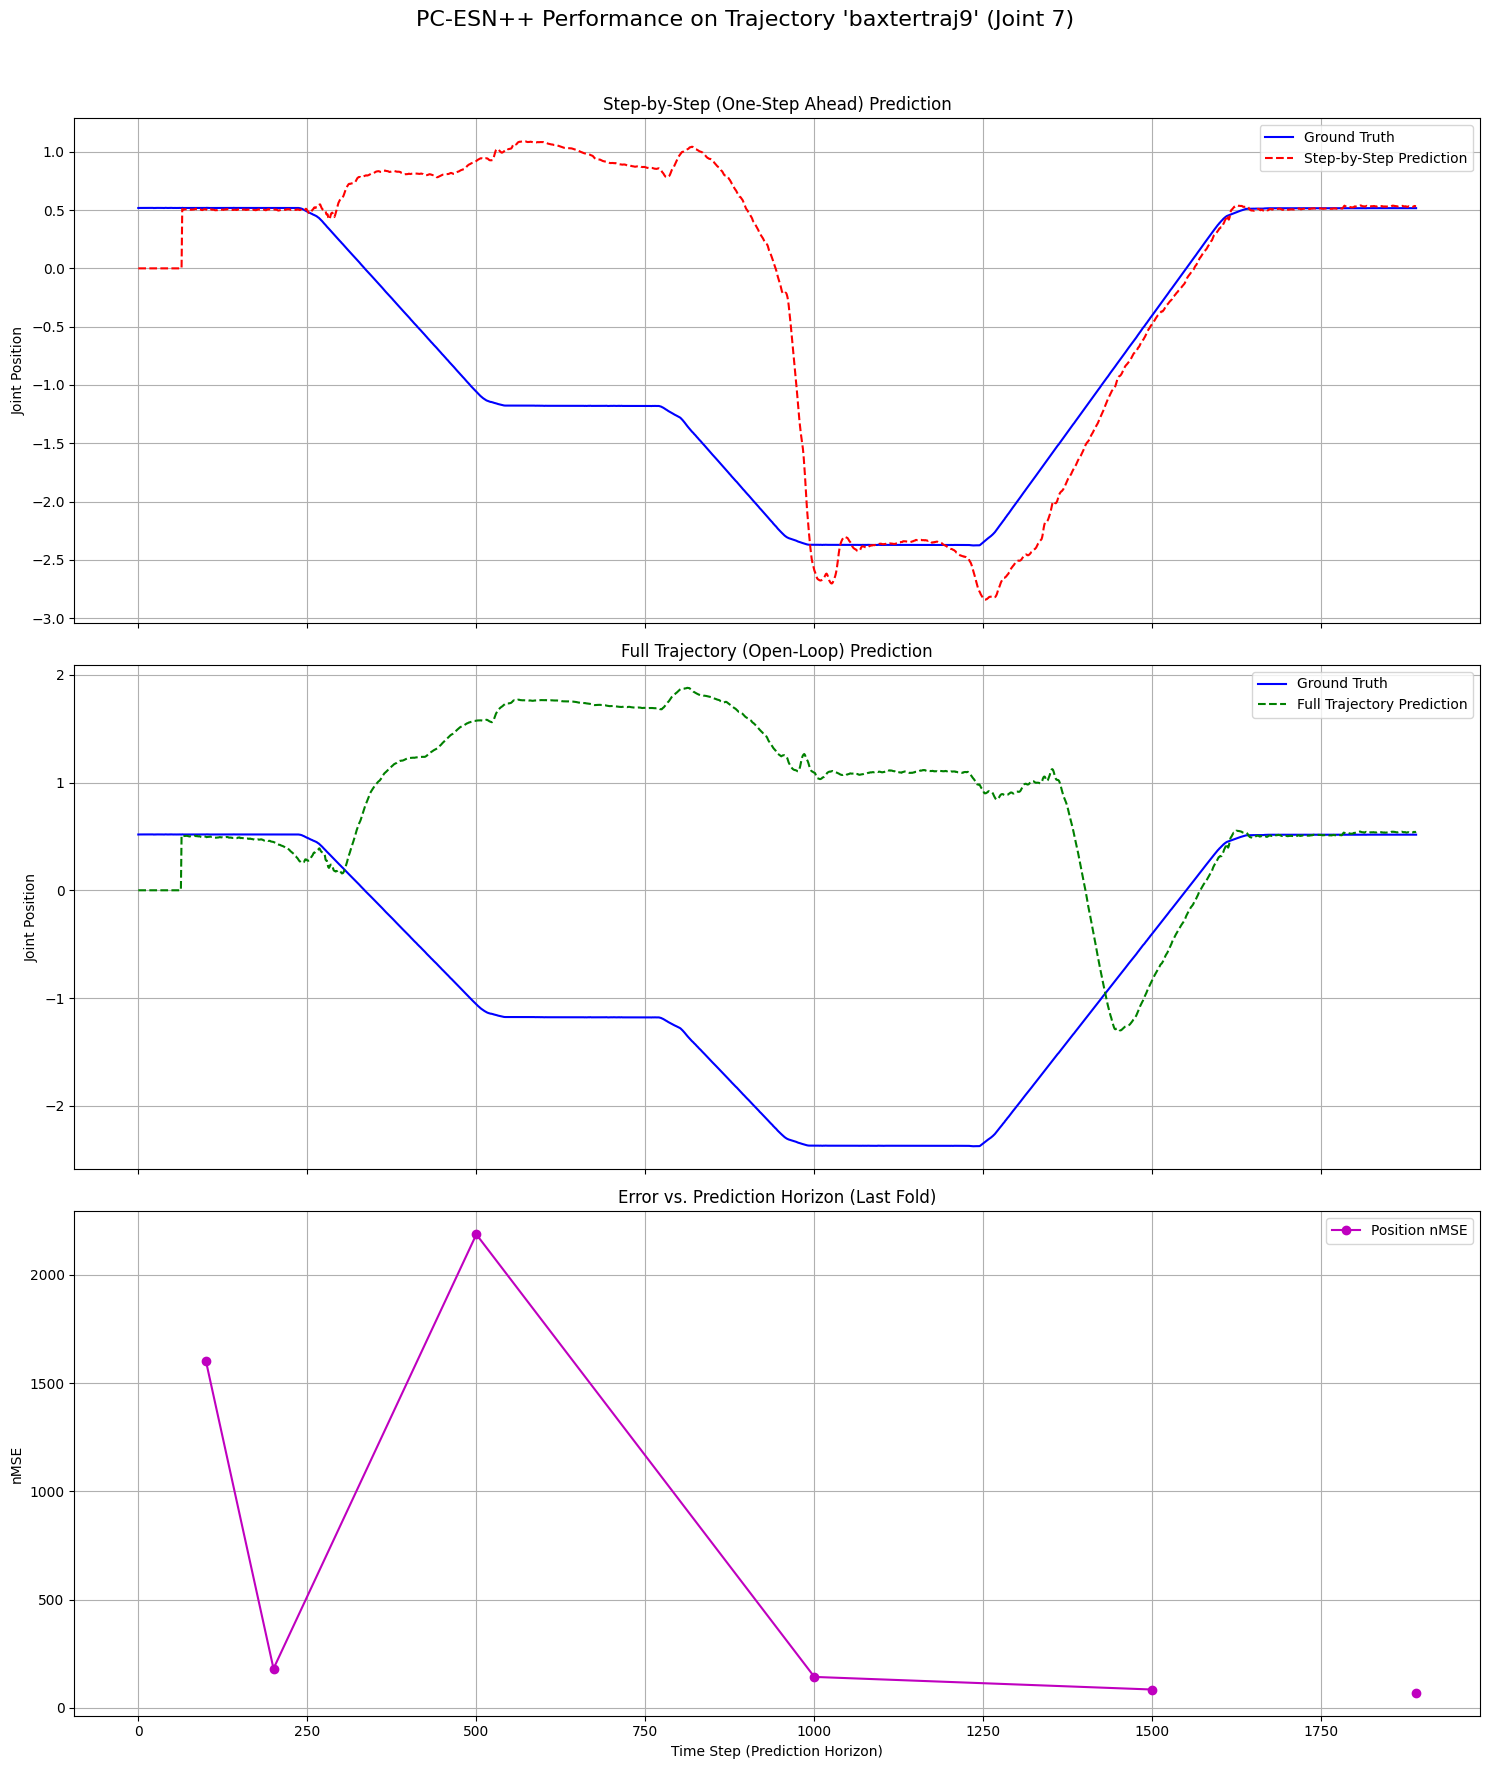

In [24]:
import matplotlib.pyplot as plt

# Visualization (from last fold)
joint_to_plot = 6
y_true_plot = last_fold_preds['true'][:, joint_to_plot]
y_pred_step_plot = last_fold_preds['step'][:, joint_to_plot]
y_pred_full_plot = last_fold_preds['full'][:, joint_to_plot]

fig, axs = plt.subplots(3, 1, figsize=(15, 18), sharex=True)
fig.suptitle(f"PC-ESN++ Performance on Trajectory '{test_key}' (Joint {joint_to_plot+1})", fontsize=16)

axs[0].plot(y_true_plot, 'b-', label='Ground Truth')
axs[0].plot(y_pred_step_plot, 'r--', label='Step-by-Step Prediction')
axs[0].set_title('Step-by-Step (One-Step Ahead) Prediction')
axs[0].set_ylabel('Joint Position'); axs[0].legend(); axs[0].grid(True)

axs[1].plot(y_true_plot, 'b-', label='Ground Truth')
axs[1].plot(y_pred_full_plot, 'g--', label='Full Trajectory Prediction')
axs[1].set_title('Full Trajectory (Open-Loop) Prediction')
axs[1].set_ylabel('Joint Position'); axs[1].legend(); axs[1].grid(True)

horizon_vals = [h for h in calculated_horizons if f'full_pos_nmse_h{h}' in results_df.columns]
horizon_errors_pos = [results_df.iloc[-1][f'full_pos_nmse_h{h}'] for h in horizon_vals]
axs[2].plot(horizon_vals, horizon_errors_pos, 'm-o', label='Position nMSE')
axs[2].set_title('Error vs. Prediction Horizon (Last Fold)')
axs[2].set_xlabel('Time Step (Prediction Horizon)'); axs[2].set_ylabel('nMSE'); axs[2].legend(); axs[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [25]:
from scipy import stats

# --- Statistical Significance Test ---
print("\n--- Example of Statistical Significance Test ---")
baseline_results = {'full_pos_nmse': results_df['full_pos_nmse'] * (1.5 + np.random.rand(10) * 0.5)}
baseline_df = pd.DataFrame(baseline_results)
t_stat, p_value = stats.ttest_rel(results_df['full_pos_nmse'], baseline_df['full_pos_nmse'])
print("Paired t-test between PC-ESN++ and Baseline (Full Trajectory nMSE):")
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
if p_value < 0.05: print("The difference is statistically significant (p < 0.05).")
else: print("The difference is not statistically significant.")


--- Example of Statistical Significance Test ---
Paired t-test between PC-ESN++ and Baseline (Full Trajectory nMSE):
T-statistic: -1.2977, P-value: 0.2267
The difference is not statistically significant.


(-1.1106227813174343,
 0.2819200095582104,
 -0.8439771473136545,
 0.47896948853999377)

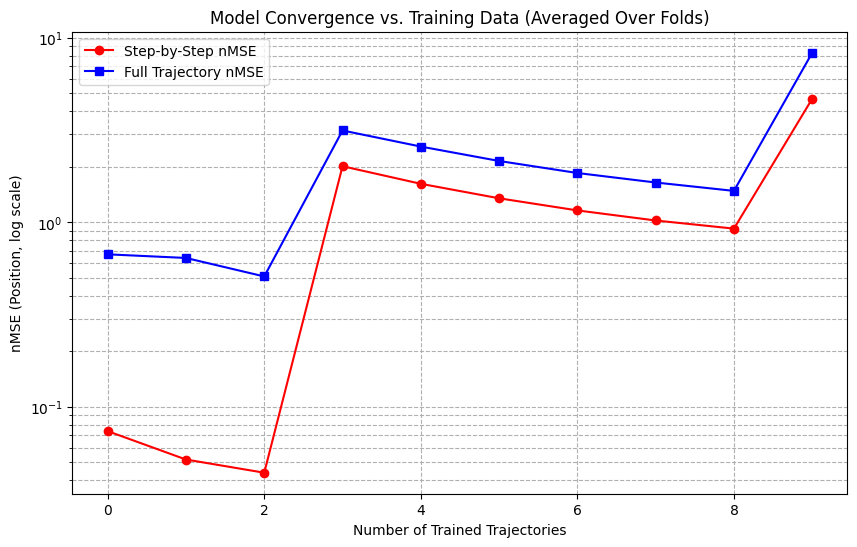

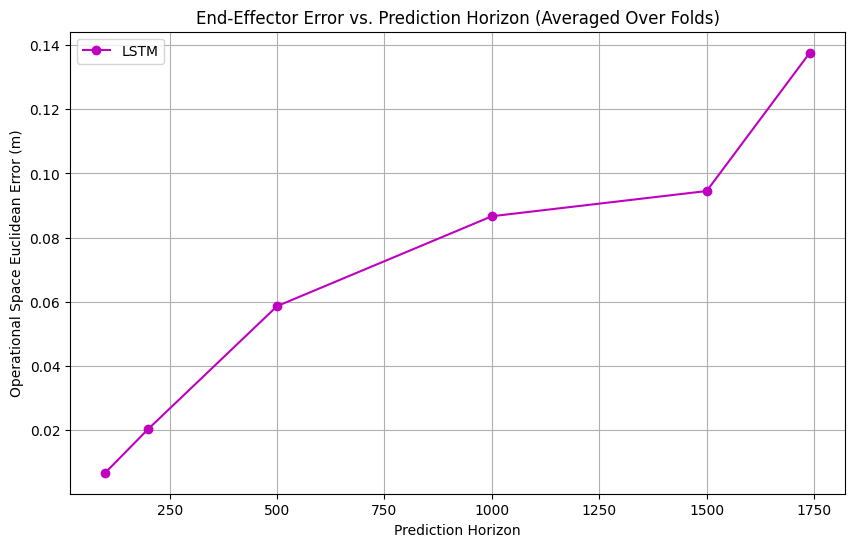

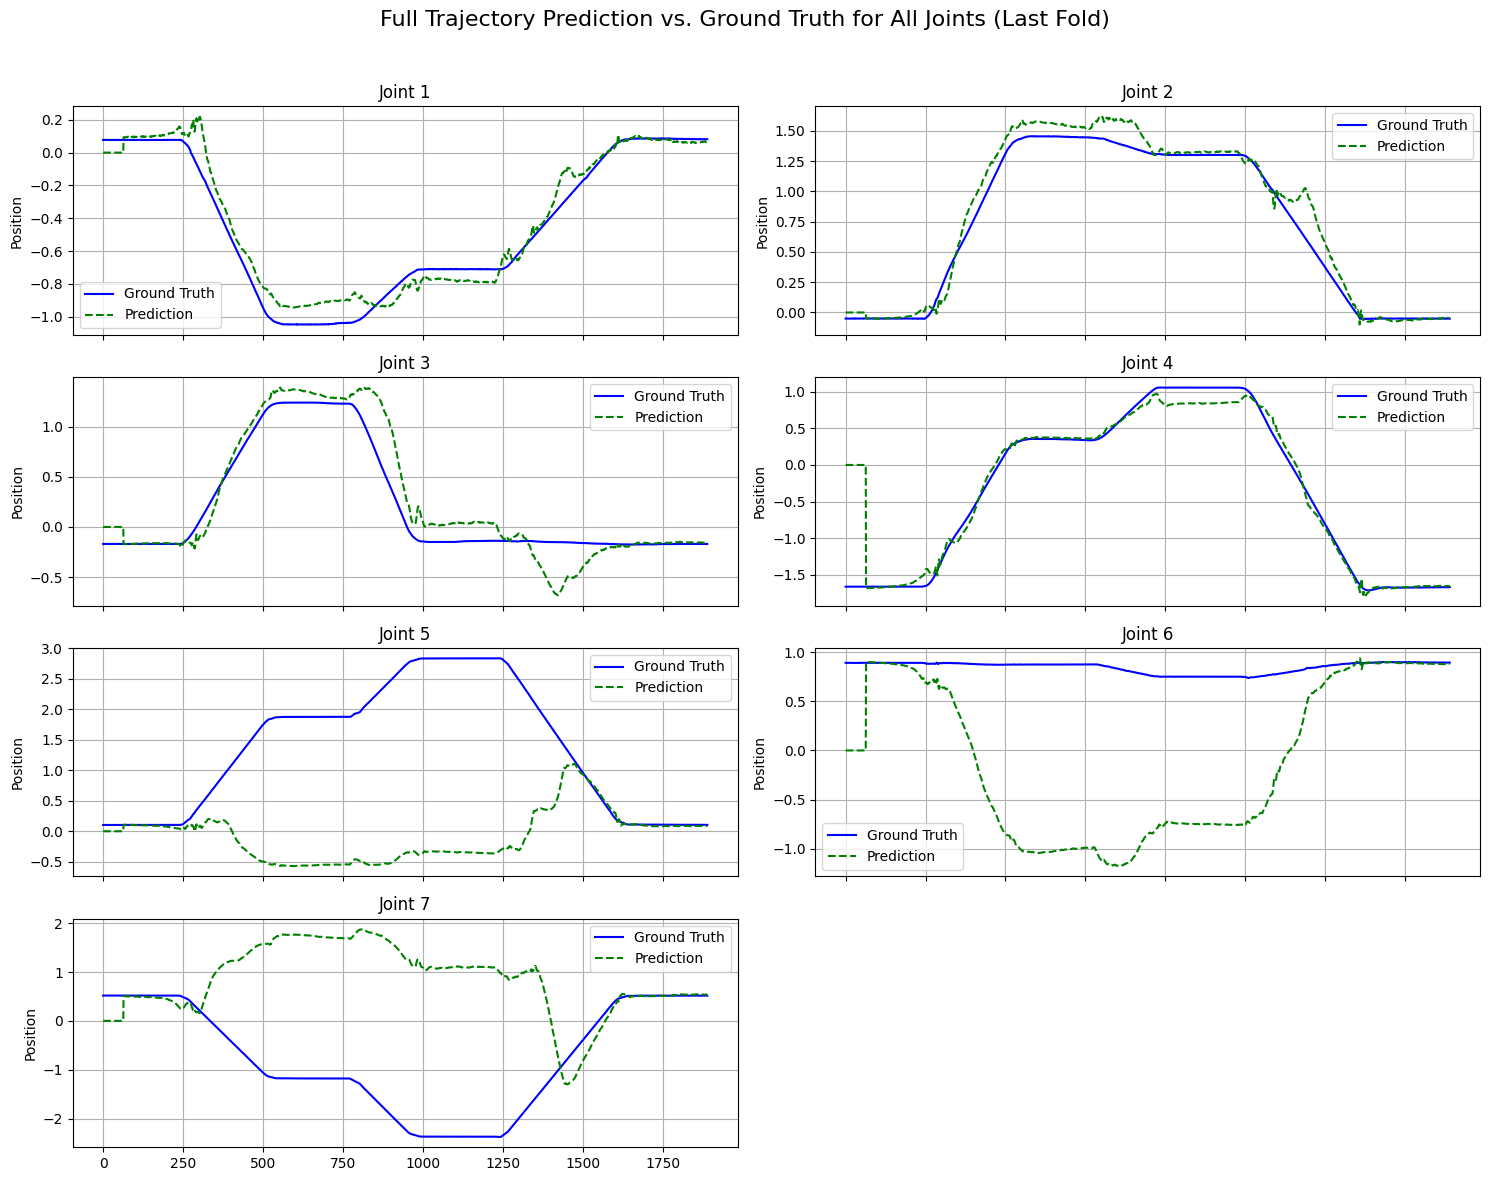

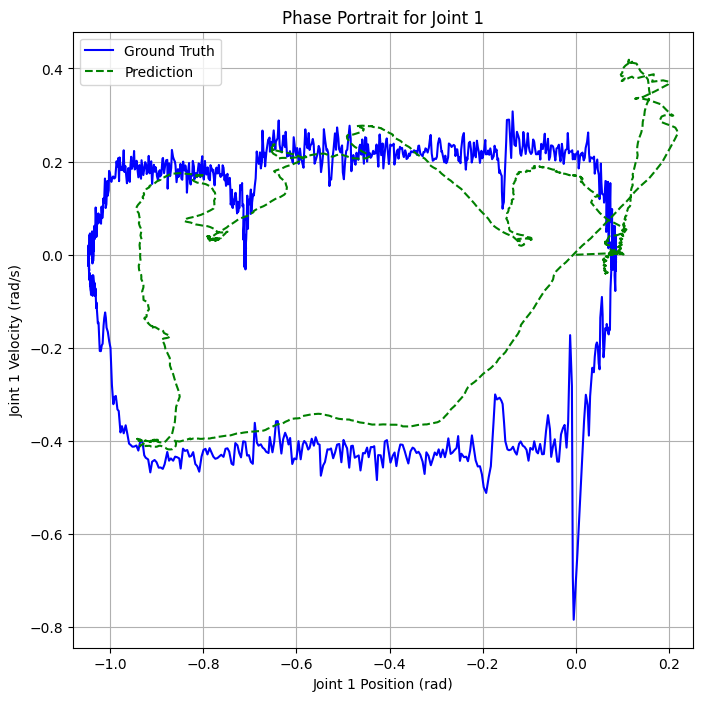

In [26]:
# --- Plot 1: Convergence Plot (Replicating Paper's Fig. 5) ---
fig1, ax1 = plt.subplots(figsize=(10, 6))
num_trajectories = np.arange(1, len(results_df) + 1)
ax1.plot(results_df['sbs_pos_nmse'].expanding().mean(), 'r-o', label='Step-by-Step nMSE')
ax1.plot(results_df['full_pos_nmse'].expanding().mean(), 'b-s', label='Full Trajectory nMSE')
ax1.set_yscale('log'); ax1.set_xlabel('Number of Trained Trajectories'); ax1.set_ylabel('nMSE (Position, log scale)')
ax1.set_title('Model Convergence vs. Training Data (Averaged Over Folds)'); ax1.legend(); ax1.grid(True, which="both", ls="--")

# --- Plot 2: Operational Space Error vs. Horizon (Replicating Paper's Fig. 6) ---
fig2, ax2 = plt.subplots(figsize=(10, 6))
horizon_cols = [f'full_euclid_err_h{h}' for h in horizons if f'full_euclid_err_h{h}' in results_df.columns]

mean_op_errors = results_df[horizon_cols].mean()
ax2.plot(calculated_horizons[:6], mean_op_errors.values, 'm-o', label='LSTM')
ax2.set_xlabel('Prediction Horizon'); ax2.set_ylabel('Operational Space Euclidean Error (m)')
ax2.set_title('End-Effector Error vs. Prediction Horizon (Averaged Over Folds)'); ax2.legend(); ax2.grid(True)

# --- Plot 3: All Joints Full Trajectory Prediction ---
fig3, axs3 = plt.subplots(4, 2, figsize=(15, 12), sharex=True)
fig3.suptitle('Full Trajectory Prediction vs. Ground Truth for All Joints (Last Fold)', fontsize=16)
axs3 = axs3.ravel()
for i in range(7):
    axs3[i].plot(last_fold_preds['true'][:, i], 'b-', label='Ground Truth')
    axs3[i].plot(last_fold_preds['full'][:, i], 'g--', label='Prediction')
    axs3[i].set_title(f'Joint {i+1}'); axs3[i].set_ylabel('Position'); axs3[i].grid(True); axs3[i].legend()
axs3[-1].set_visible(False)
plt.tight_layout(rect=[0, 0, 1, 0.96]);

# --- Plot 4: Phase Portrait for a Sample Joint (SAFEGUARD ADDED) ---
fig4, ax4 = plt.subplots(figsize=(8, 8))
joint_to_plot = 0

ax4.plot(last_fold_preds['true'][:, joint_to_plot], last_fold_preds['true'][:, joint_to_plot + 7], 'b-', label='Ground Truth')
ax4.plot(last_fold_preds['full'][:, joint_to_plot], last_fold_preds['full'][:, joint_to_plot + 7], 'g--', label='Prediction')
ax4.set_xlabel(f'Joint {joint_to_plot+1} Position (rad)'); ax4.set_ylabel(f'Joint {joint_to_plot+1} Velocity (rad/s)')
ax4.set_title(f'Phase Portrait for Joint {joint_to_plot+1}'); ax4.legend(); ax4.grid(True); ax4.axis('equal')